<a href="https://colab.research.google.com/github/LorenzEh/Basic-Neural-Network/blob/main/Neural_Net_Basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building a Basic Neural Network

The plan is to create a simple Neural Network, which is capable of identifying hand-written digits. The following material has been used:

1. Videos of 3Blue1Brown series on neural nets (https://www.youtube.com/watch?v=aircAruvnKk&list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi)
2. Nielsen's free book (http://neuralnetworksanddeeplearning.com/chap1.html)
3. A video by Bot Academy (https://www.youtube.com/watch?v=9RN2Wr8xvro)
4. Another video by Artem Kirsanov (https://www.youtube.com/watch?v=SmZmBKc7Lrs&t=990s)

Since hyperlinks do not always work when loading up Colab Notebooks on GitHub, I decided to just include the links.


In [9]:
!pip install datasets

In [10]:
# libraries
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

We create a neural net with  3 layers, an input layer, a hidden layer, and an output layer (note, that this picture does not show the correct number of neurons, which is 784 in the input-, 20 in the hidden-, and 10 in the output layer):




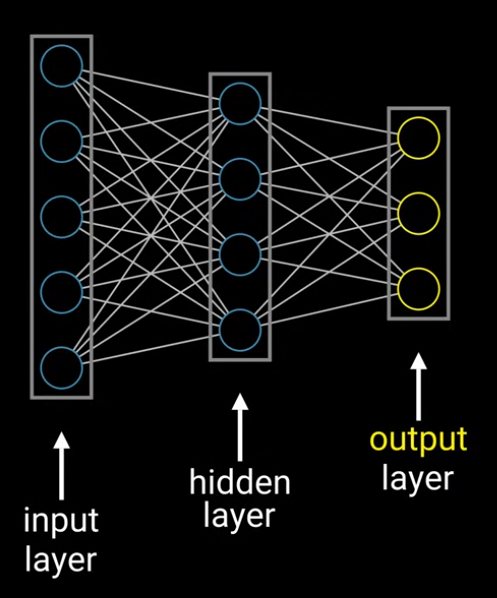


First, we initialise the weights and biases with random numbers, or zeros respectively.

We follow the logic of the "Bot Academy" video:
```
w = weights, b = bias, i = input, h = hidden, o = output, l = label
e.g. w_i_h = weights from input layer to hidden layer
```

In [11]:
# the weights connecting the input layer with the hidden layer have a shape of 20 (this is the number of the neurons in the hidden layer),
# and 784 (this is the number of the inputs, which translates to 28x28 pixels)
w_i_h = np.random.uniform(-0.5, 0.5, (20, 784))
# the weights connecting the hidden layer with the output layer have a shape of 20 (this is the number of the neurons in the hidden layer),
# and 10 (this is the number of the outputs, which translates to the numbers 0-9)
w_h_o = np.random.uniform(-0.5, 0.5, (10, 20))
# we initialize the biases with zeros, we want to start with an unbiased neural network
b_i_h = np.zeros((20, 1))
b_h_o = np.zeros((10, 1))

With the step above, we basically built the neural network and initialized it with random numbers. We have 784 input neurons, which correspond to the 28×28 pixels of each input image. Each number we feed into the model is a 28×28 pixel image, and each pixel value is passed to one input neuron. The hidden layer follows with 20 neurons, and finally, the output layer has 10 neurons—one for each digit from 0 to 9. The model will "choose" one of these as its prediction.

During training, the weights and biases between the layers are adjusted. The input neurons simply "hold" the pixel values and do not change. The output layer computes the final prediction based on the activations it receives from the hidden layer, and it is also affected by the training process as its weights and biases are updated to improve accuracy.

Lets load the data next, and take a look at some examples

In [12]:
# load the dataset from tensorflow_datasets
ds = tfds.load('mnist', split='train', as_supervised=True)

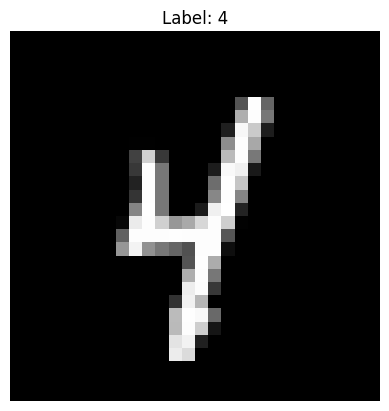

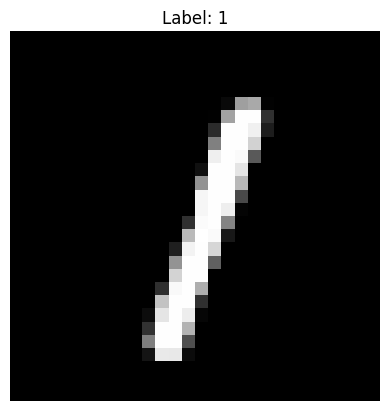

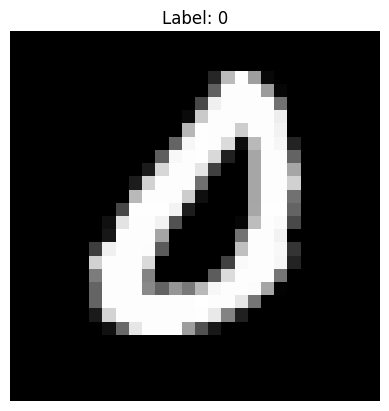

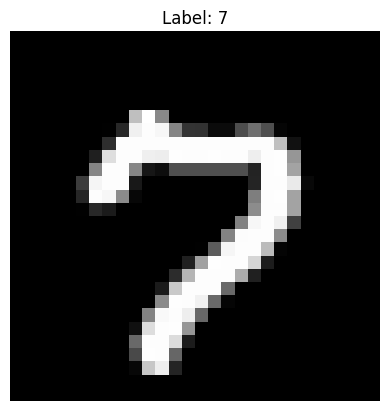

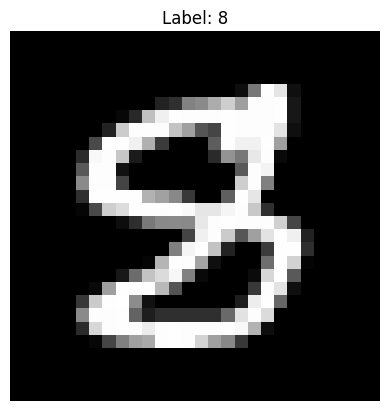

In [13]:
# show a few examples, of the 28x28 pictures of numbers
for image, label in ds.take(5):
    plt.imshow(image.numpy().squeeze(), cmap='gray')
    plt.title(f"Label: {label.numpy()}")
    plt.axis("off")
    plt.show()

Since we will make of Stochastic Gradient Descent (SGD), we create mini-batches of size one and shuffle the training data set: `train_ds_unbatched.shuffle(1024).batch(1)`. SDG implies updating the weights and biases for each batch at a time. This has benefits in terms of memory efficiency and works better for large datasets. I choose the batch size of one for showcasing purposes, so each image gets processed at a time. In my opinion it makes the explanation of the maths afterwards more clear and easier to follow. In practice larger batches (e.g., size 32) would typically be used for faster convergence and better hardware utilization. In case of a larger batch size it would be necessary to average the gradients based on batch-size before updating the weights and biases.


In [14]:
# data prep:
ds = ds.map(lambda img, label: (tf.cast(tf.reshape(img, [-1]), tf.float32) / 255.0, label)) # normalize and flatten image
ds = ds.shuffle(1024) # shuffle the unbatched dataset

dataset_size = tf.data.experimental.cardinality(ds).numpy()
test_size = int(0.10 * dataset_size)
train_size = dataset_size - test_size

# split first
train_ds_unbatched = ds.take(train_size)
test_ds_unbatched = ds.skip(train_size)

# create the train and test datasets
train_ds = train_ds_unbatched.shuffle(1024).batch(1) # batch size 1 to make the explanation afterwards easier (should be larger in "real" setting)
test_ds = test_ds_unbatched.batch(1)

# Explanation of the training loop:
```
for epoch in range(epochs):
    nr_correct = 0
    sample_count = 0

    for img_tensor, label_tensor in train_ds:  
        img = tf.reshape(img_tensor, [-1, 1]).numpy()  # (784, 1)
        label = label_tensor.numpy()[0]  # scalar label

        l = np.zeros((10, 1))
        l[label] = 1  # One-hot encoding

        # forward pass (input -> hidden -> output)
        h_pre = b_i_h + w_i_h @ img
        h = 1 / (1 + np.exp(-h_pre))  # sigmoid
        o_pre = b_h_o + w_h_o @ h
        o = 1 / (1 + np.exp(-o_pre))  # sigmoid

        # accuracy check
        predicted_label = np.argmax(o)
        true_label = label
        if predicted_label == true_label:
            nr_correct += 1
        sample_count += 1

        # backpropagation
        delta_o = (2.0 / len(o)) * (o - l) * (o * (1 - o))  # ouput layer gradient
        delta_h = w_h_o.T @ delta_o * (h * (1 - h))  # hidden layer gradient

        w_h_o += -learn_rate * delta_o @ h.T  # update output weights, one image at a time (SDG) for showcasing purposes
        b_h_o += -learn_rate * delta_o

        w_i_h += -learn_rate * delta_h @ img.T  # update hidden weights
        b_i_h += -learn_rate * delta_h

    print(f"Epoch {epoch+1} Training Accuracy: {round((nr_correct / sample_count) * 100, 2)}%")

```


We start with the outer training loop, for each epoch, the code within the loop gets executed. Additionally, we store the sample count, as well as the number of correctly identified samples in 2 variables. We do this to check how well the model is performing:
```
for epoch in range(epochs):
    nr_correct = 0
    sample_count = 0
```
Next, the inner training loop follows. Additionally, we flatten the image data (`img`) and transform it to a tensor. `label` gets transformed into a tensor as well. Those steps are necessary to enable the calculations afterwards.
```
    for img_tensor, label_tensor in train_ds:  
        img = tf.reshape(img_tensor, [-1, 1]).numpy()  
        label = label_tensor.numpy()[0]  

```
Next, one-hot encode the labels. This means tranforming the data from a categorical value (in our case numbers from 0-9) into a vector:

```
        l = np.zeros((10, 1))
        l[label] = 1
```

If we had the label 3, we would get the vector (since we are starting to count form 0 the fourth number is set to "1"):

\begin{pmatrix}
0 \\
0 \\
0 \\
1 \\
0 \\
0 \\
0 \\
0 \\
0 \\
0
\end{pmatrix}

This aligns with our output layer, which also has 9 neurons.

### Forward propagation:

We start of with the forward step from the input to the hidden layer:
```
        h_pre = b_i_h + w_i_h @ img   
        h = 1 / (1 + np.exp(-h_pre))  
```
The first calculation we multiply the weights ($w_{ih}$) with the input ($\text{img}$) and add the bias ($b_{ih}$):

$$
h_{\text{pre}} = b_{ih} + w_{ih} \cdot \text{img}
$$

The weights act like "importance knobs" between neurons. Each of the 20 hidden neurons has 784 individual knobs (one per input pixel). A higher weight means its corresponding input pixel has more influence on the hidden neuron's output.

$$W_{ih} \in \mathbb{R}^{20 \times 784}$$

The bias is a hidden neuron's "personal preference" to activate. It lets the neuron fire even if all input pixels are zero (like a baseline adjustment). The bias gives each output neuron an independent baseline tendency to activate, regardless of input from the hidden layer. Each of the 20 hidden neurons has its own unique bias.

$$b_{ih} \in \mathbb{R}^{20 \times 1}$$

The weighted sum ($w_{ih} \times \text{img}$) decides how much the input affects the neuron, while the bias ($b_{ih}$) sets how easy it is for the neuron to activate. The combination ($h_{\text{pre}}$) determines the hidden neuron's response.

Lastly, we apply a sigmoid function to scale the data between 0 and 1; this is also known as the activation function. It introduces non-linearity, allowing the model to capture more complex patterns than a purely linear model could.Non-linearity enables the network to combine multiple neurons in complex ways, allowing them to collectively identify patterns like circular shapes that would be impossible for linear models. The sigmoid is also smooth and differentiable, making it well-suited for backpropagation during training:

$$
h = \frac{1}{1 + \exp(-h_{\text{pre}})}
$$


We do the essentially the same procedure from the hidden to the output layer. This time we mulitply the hidden layer with the weights from the hidden to the output layer and add the respective weights ($o_{\text{pre}} $). Furthermore, we make use of a sigmoid acitvation function ($o$):

```
        o_pre = b_h_o + w_h_o @ h
        o = 1 / (1 + np.exp(-o_pre))
```

in mathematical notation, that would be:

$$
o_{\text{pre}} = b_{ho} + w_{ho} \cdot {h}
$$


$$
o = \frac{1}{1 + \exp(-o_{\text{pre}})}
$$

where

$$W_{ho} \in \mathbb{R}^{10 \times 20}$$

and
$$b_{ho} \in \mathbb{R}^{10 \times 1}$$

The weights $W_{ho}$​ (a 10×20 matrix) connect all 20 hidden neurons to the 10 output neurons. Each weight determines how strongly a hidden neuron's output influences an output neuron's result. The bias $b_{ho}$​ (a 10×1 vector) gives each output neuron a baseline tendency to activate. This adjusts the neuron's output independently of the hidden layer's signals, shifting its 'starting point' before applying the sigmoid function.

### Accuracy checks:

The predicted label is determined by the index of the maximum value in the output vector:

```
        predicted_label = np.argmax(o)
        true_label = label  
        if predicted_label == true_label:
            nr_correct += 1
        sample_count += 1
```

The accuracy is calculated by comparing `predicted_label` with `true_label`. We will use `nr_correct / sample_count` later on for our print statement. This lines of code have the sole purpose to show us how well the training is going.

### Back propagation:

We are basically propagating the error from the end back to the start! We start of from the output to the hidden layer, and go further form the hidden to the input layer.

**We start of the calculation of the output layer gradient:**

```
        delta_o = (2.0 / len(o)) * (o - l) * (o * (1 - o))
```

We compute the error at the output layer ($\delta_o$) using:

1. The scaled difference between predicted and true outputs: $\frac{2}{10}(o - l)$

    - The $\frac{2}{10}$ factor comes from the derivative of MSE loss:
      - The loss function for a single training example is:

      $$E = \frac{1}{n} \sum_{i=1}^{n} (o_i - l_i)^2$$  where:

        $n$ = number of output neurons (10 in our case)

        $o_i$ = predicted value of output neuron $i$

        $l_i$ = true label value (0 or 1) for neuron $i$

        The derivative of MSE with respect to output $o_i$ is:

        $$\frac{\partial E}{\partial o_i} = \frac{2}{n}(o_i - l_i)$$

        The 2 comes from the derivative of the squared term: $\frac{d}{dx}x^2 = 2x$

        The $\frac{1}{n}$ comes from the "mean" part of MSE (we average across all outputs)

2. Multiplied by the derivative of the sigmoid function: $o(1 - o)$

      - The sigmoid activation derivative for an output neuron $i$:

      $$\frac{\partial o_i}{\partial (o_{\text{pre}_i})} = o_i(1 - o_i)$$

      This term is largest when $o_i = 0.5$ (uncertain prediction) and smallest when $o_i$ is near 0 or 1 (confident prediction).

3. Resulting in: $\delta_o = \frac{2}{n}(o - l) \times o(1 - o)$ where $n=10$

**Example:**

Suppose for *one* output neuron:

- $l = 1$ (true label)
- $o = 0.2$ (prediction)
- $n = 10$

Calculation:

- MSE derivative = $\frac{2}{10}(0.2 - 1) = 0.2 \times (-0.8) = -0.16$

- Sigmoid derivative = $0.2 \times (1 - 0.2) = 0.16$

- Combined $\delta_o$ = $-0.16 \times 0.16 = -0.0256$

This negative delta will:

- Increase the neuron's weights (since we use `+= -learn_rate * delta` for updatgin the weights later on)

- Make future predictions closer to 1

**We calculate the gradient at the hidden layer next:**

```
        delta_h = w_h_o.T @ delta_o * (h * (1 - h))
```

This line of code computes the error at the hidden layer ($\delta_h$) by:

1. Backpropagating output error through weights: $w_{ho}^T \cdot \delta_o$

    - $w_{ho}^T$: Transposed weights (20×10 → 10×20, what was connecting hidden→output now flows backward). Considering the linear relationship:

    $$o_{\text{pre}} = w_{ho} \cdot h + b_{ho}$$ it is the derivative of $o_{\text{pre}}$ with respect to $h$:

    $$\frac{\partial h}{\partial o_{\text{pre}}} = w_{ho}^T$$

    - $\delta_o$: Output error gradient (10×1 vector, which we caluclated before)

    By calculating $w_{ho}^T \cdot \delta_o$ we essentially multiply "the weight to wrong output" with "that output's error". A hidden neuron will get a large $\delta_h$ if it has strong connections ($w_{ho}$ large) to output neurons with large errors ($\delta_o$ large)

2. Multiplied by the derivative of sigmoid at hidden layer: $h(1 - h)$

    - Same as before:

    $$\frac{\partial h_i}{\partial (h_{\text{pre}_i})} = h_i(1 - h_i)$$

3. Resulting in: $\delta_h = (w_{ho}^T \delta_o) \cdot h(1 - h)$

**Example:**

Suppose we have 10 output neurons and 20 hidden neurons, so the weight matrix $w_{ho}$ is of shape (10, 20). Then $w_{ho}^T$ is (20, 10) and $\delta_o$ is a (10, 1) vector.

Let’s take one hidden neuron (say *neuron 5*), and suppose:

- The weights from this neuron to the output layer are:
  $w_{ho}^T = [0.3, -0.1, 0.2, 0.0, 0.5, -0.4, 0.2, 0.1, -0.2, 0.1]$

- The corresponding $\delta_o$ vector is:
  $\delta_o = [-0.0256, 0.01, -0.03, 0.005, 0.02, -0.015, 0.01, -0.005, 0.005, -0.01]$

- The dot product for those two is $(0.3 \times -0.0256) + (-0.1 \times 0.01) + (0.2 \times -0.03) + \dots + (0.1 \times -0.01) = -0.015$

- This was the calculation of $w_{ho}^T \delta_o$ for neuron 5 in the hidden layer. Now we need to calculate the derivative of the sigmoid function $(h(1-h))$:

    - We assume, that the output of neuron 5 in the hidden layer was $h = 6$, the derivate of the sigmoid function would than be: $h(1-h) = 0.6 \times (1 - 0.6) = 0.6 \times 0.4 = 0.24$

- Now we just multiply $w_{ho}^T \delta_o$ with $h(1-h)$ for the final result: $\delta_h$ = $-0.015 \times 0.24 = -0.0036$

This is the gradient signal for hidden neuron 5, indicating how much its weights and bias should be adjusted.
### Updating the weights and biases

The updates of the weights and biases are based on the gradients we calculated in the steps before. For the output layer the updates are based on the output error gradient $\delta_o$ and the activations from the hidden layer $h$:

```
        w_h_o += -learn_rate * delta_o @ h.T
```

### Weight update:

- The operation ($\Delta w_{ho} = -\eta \cdot \delta_o \cdot h^T$) is derived from the gradient descent rule:

    $$\Delta w_{ho} = -\eta \frac{\partial E}{\partial w_{ho}}$$
    
    This says: Change the weight from hidden to output by a small amount ($\Delta w_{ho}$), moving in the direction that reduces the error ($E$). $-\eta$ is the learning rate, which lets us control how big each step is. The derivative tells us the direction and strength of change needed.
    We calculate the gradient for weights between the hidden layer ($h$) and the output layer ($o$) next:
    
    $$\frac{\partial E}{\partial w_{ho}} = \delta_o \cdot h^T$$
    
    $\delta_o $ is the error term for the output neuron (how much it missed the target). $h^T$ is the output of the hidden layer, transposed into a row vector so it matches the weight matrix shape. Multiplying these gives the gradient — the direction and amount of change needed for each weight. Making use of this gradient the weights can then be updated:
    
    $$\Delta w_{ho} = -\eta \cdot \delta_o \cdot h^T$$

    This uses the gradient and scales it by the learning rate $\eta$, and applies the negative sign to move in the direction that reduces error (downhill in gradient descent).

**Example:**

Suppose we only want to update one weight: from hidden neuron 7 to output neuron 2:

$$\Delta w_{ho}[2,7] = -\eta \cdot \delta_{o,2} \cdot h_7$$

- $delta_{o,2}$ is the error for output neuron 2

- $h_7$ is the activation (output) of hidden neuron 7

If:

- $\delta_{o,2} = -0.4$ (prediction was too low (underestimated))

- $h_7 = 0.9$ (hidden neuron was highly active)

- $\eta = 0.1$ (thats just the learning rate)

Then:

$$\Delta w_{ho}[2,7] = -0.1 \cdot (-0.4) \cdot 0.9 = 0.036$$

This weight increases (positive update), because:

- We were too low in prediction

- That hidden neuron was strongly active

- So we strengthen the connection from that hidden neuron to the output neuron

In simple terms: *If we were too low in prediction and a hidden neuron was strongly active, we boost the connection so it contributes more next time.*

### Bias update:

The bias vector for the output layer is updated using the error signal $\delta_o$ from each output neuron:

```
        b_h_o += -learn_rate * delta_o
```

In mathematical notation:

$$\Delta b_{ho} = -\eta \cdot \delta_o$$

Where:

- $\eta$ is the learning rate

- $\delta_o$ is the error at the output layer

- $h^T$ is the transpose of the hidden layer output (used for correct matrix multiplication shape)

The intuition:

- Each output neuron has an associated bias term. Which is updated

- Unlike weights, the bias doesn’t depend on any input — it’s like a "free offset" that lets the neuron shift its activation threshold. Keep the activation formula for a single neuron in mind: $\text{activation} = \sigma(w_0 a_0 + w_1 a_1 + \dots + w_{N-1} a_{N-1} + b)$, where $a$ is the input activations from the previous layer or features, $w$ the weights between last layer and the activation we`re looking at ($\text{activation}$) and $b$ the bias for this neuron.

- Since it’s not connected to an earlier neuron, we don’t multiply it by any input or activation during the update.

Updating the weights between input and hidden layer follows the same workflow, but this time we use the hidden layer error gradient $\delta_h$, and the input layer $\text{img}^T$:
```
        w_i_h += -learn_rate * delta_h @ img.T
        b_i_h += -learn_rate * delta_h
```
- This corresponds to the following formulas:

- Weight update: $\Delta w_{ih} = -\eta \cdot \delta_h \cdot \text{img}^T$

- Bias update: $\Delta b_{ih} =  - \eta \times \delta_h$

Where:

- $\eta$ is the learning rate

- $\delta_h$ is the error at the hidden layer

- $\text{img}^T$ is the transpose of the input vector (e.g., an image flattened into a column)

The intuition:

- It's essentially the same procedure as before. The only difference are the inputs ($\text{img}^T$ instead of $h^T$ and $\delta_h$ instead of $\delta_o$). Besides the different inputs the same procedure as before can be applied:

  - Each weight between the input and hidden layer is updated based on how much that input contributed to the hidden layer's error.

  - The bias update is again based directly on the error at each hidden neuron.

Lasty, we just print the accuracy:

```
 print(f"Epoch {epoch+1} Accuracy: {round((nr_correct / sample_count) * 100, 2)}%")
```


In [15]:

learn_rate = 0.05
epochs = 6

for epoch in range(epochs):
    nr_correct = 0
    sample_count = 0

    for img_tensor, label_tensor in train_ds:
        img = tf.reshape(img_tensor, [-1, 1]).numpy()  # (784, 1)
        label = label_tensor.numpy()[0]  # scalar label

        l = np.zeros((10, 1))
        l[label] = 1  # One-hot encoding

        # forward pass (input -> hidden -> output)
        h_pre = b_i_h + w_i_h @ img
        h = 1 / (1 + np.exp(-h_pre))  # sigmoid
        o_pre = b_h_o + w_h_o @ h
        o = 1 / (1 + np.exp(-o_pre))  # sigmoid

        # accuracy check
        predicted_label = np.argmax(o)
        true_label = label
        if predicted_label == true_label:
            nr_correct += 1
        sample_count += 1

        # backpropagation
        delta_o = (2.0 / len(o)) * (o - l) * (o * (1 - o))  # ouput layer gradient
        delta_h = w_h_o.T @ delta_o * (h * (1 - h))  # hidden layer gradient

        w_h_o += -learn_rate * delta_o @ h.T  # update output weights and biases based on one image at a time (SDG) for showcasing purposes
        b_h_o += -learn_rate * delta_o

        w_i_h += -learn_rate * delta_h @ img.T  # update hidden weights
        b_i_h += -learn_rate * delta_h

    print(f"Epoch {epoch+1} Training Accuracy: {round((nr_correct / sample_count) * 100, 2)}%")

Epoch 1 Training Accuracy: 63.99%
Epoch 2 Training Accuracy: 86.75%
Epoch 3 Training Accuracy: 89.05%
Epoch 4 Training Accuracy: 90.2%
Epoch 5 Training Accuracy: 90.89%
Epoch 6 Training Accuracy: 91.39%


Lasty, let the testing data run through our network. We calculate a test accuracy and print some of the images which have been classified wrongly by the algorithm.

Test Accuracy: 91.7%

Examples of wrong predictions from the final model:
Wrong prediction 1:
  True Label: 2, Predicted Label: 4


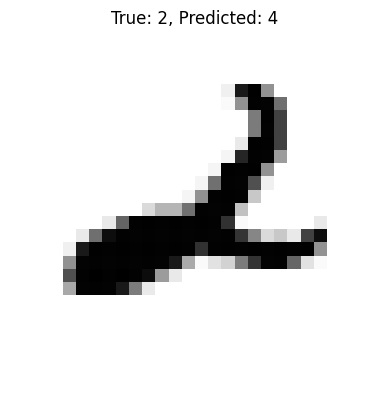

Wrong prediction 2:
  True Label: 5, Predicted Label: 3


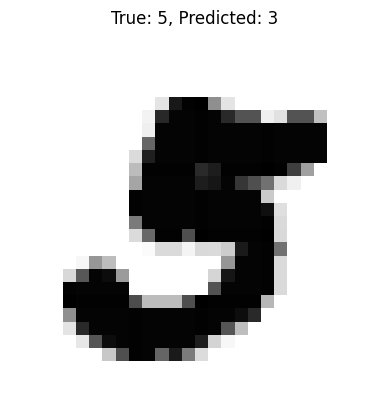

Wrong prediction 3:
  True Label: 3, Predicted Label: 8


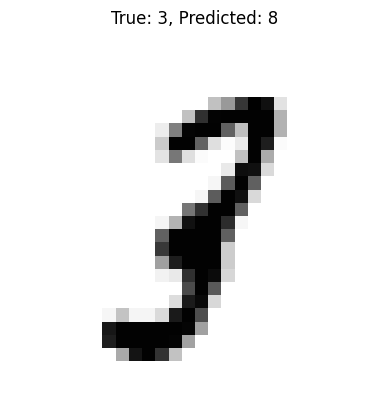

Wrong prediction 4:
  True Label: 5, Predicted Label: 3


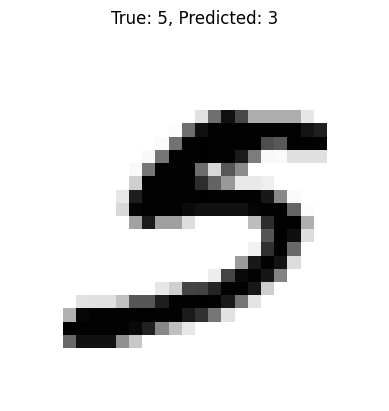

Wrong prediction 5:
  True Label: 9, Predicted Label: 1


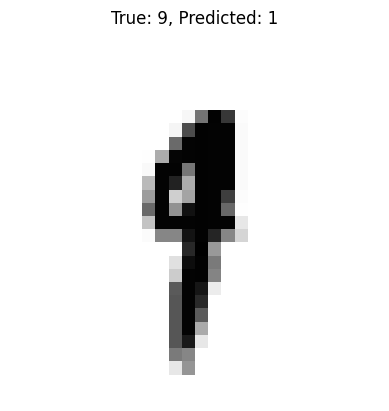

In [16]:
wrong_predictions = []
test_nr_correct = 0
test_sample_count = 0

for img_tensor, label_tensor in test_ds:  # Use test_ds for evaluation
    img = tf.reshape(img_tensor, [-1, 1]).numpy()
    label = label_tensor.numpy()[0] # Get the scalar label

    l = np.zeros((10, 1))
    l[label] = 1

    # Forward pass with the trained model
    h_pre = b_i_h + w_i_h @ img
    h = 1 / (1 + np.exp(-h_pre))

    o_pre = b_h_o + w_h_o @ h
    o = 1 / (1 + np.exp(-o_pre))

    predicted_label = np.argmax(o)
    true_label = np.argmax(l)

    if predicted_label == true_label:
        test_nr_correct += 1
    else:
        wrong_predictions.append({
            'image': img.copy(),
            'true_label': true_label,
            'predicted_label': predicted_label
        })

    test_sample_count += 1

print(f"Test Accuracy: {round((test_nr_correct / test_sample_count) * 100, 2)}%")


# now, print information about wrong predictions
print("\nExamples of wrong predictions from the final model:")
for i, wrong_pred in enumerate(wrong_predictions[:5]): # Print up to the first 10 wrong predictions
    print(f"Wrong prediction {i+1}:")
    print(f"  True Label: {wrong_pred['true_label']}, Predicted Label: {wrong_pred['predicted_label']}")

    # display the image of the wrong prediction
    plt.imshow(wrong_pred['image'].reshape(28, 28), cmap="Greys")
    plt.title(f"True: {wrong_pred['true_label']}, Predicted: {wrong_pred['predicted_label']}")
    plt.axis("off")
    plt.show()